# Project Overview

This notebook explores a **computer vision approach** for predicting both **clothing categories** and **visual attributes** using a filtered version of the **DeepFashion dataset**.  
The dataset was balanced through **undersampling and oversampling** techniques applied to the training set to reduce bias and improve generalization.

The **data preprocessing** phase involved multiple iterative experiments for filtering, cleaning, and label alignment.  
While those steps are not detailed here, the **final preprocessed dataset** used for training is included.

The model is implemented in **TensorFlow/Keras**. It uses a **shared EfficientNetB0 backbone** pretrained on ImageNet to extract high-level visual features, followed by two task-specific heads:
- A **softmax classifier** for predicting one of 16 clothing categories.  
- A **sigmoid layer** for multi-label prediction of 18 visual attributes (e.g., *floral, denim, short_sleeve*).

A custom **Balanced Accuracy** metric is introduced to handle class imbalance across categories.  
This multitask setup enables the model to jointly learn **global fashion categories** and **fine-grained visual details**, leveraging shared visual representations to enhance both tasks.


# SET UP

In [ ]:
!git clone https://github.com/BrunaCussiol/fashion_classifier.git

In [2]:
# Copy image folder
!mv fashion_classifier/* /content/


In [ ]:
#Download compressed preprocessed data

import gdown

file_id = "16yYsyLpMAss0jQp9wFBAPzwALtfNFTlC"
url = f"https://drive.google.com/uc?id={file_id}"

output = "img_filtered.zip"

gdown.download(url, output, quiet=False)


In [11]:
# unzip img_filtered.zip in data/content
!unzip /content/img_filtered.zip -d /content/data


A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/data/img_filtered/train/Tonal_Check-Patterned_Blouse/img_00000021_crop.jpg  
  inflating: /content/data/img_filtered/train/Tonal_Check-Patterned_Blouse/img_00000056_crop.jpg  
  inflating: /content/data/img_filtered/train/Tonal_Check-Patterned_Blouse/img_00000057_crop.jpg  
  inflating: /content/data/img_filtered/train/Tonal_Check-Patterned_Blouse/img_00000069_crop.jpg  
   creating: /content/data/img_filtered/train/Tonal_Crocodile-Patterned_Dress/
  inflating: /content/data/img_filtered/train/Tonal_Crocodile-Patterned_Dress/img_00000002_crop.jpg  
  inflating: /content/data/img_filtered/train/Tonal_Crocodile-Patterned_Dress/img_00000005_crop.jpg  
   creating: /content/data/img_filtered/train/Tonal_Feather-Patterned_Cami_Jumpsuit/
  inflating: /content/data/img_filtered/train/Tonal_Feather-Patterned_Cami_Jumpsuit/img_00000002_crop.jpg  
  inflating: /content/data/img_filtered/train/Tonal_Feather-Patterned

# READ DATA


In [7]:
from src.utils_io import read_dfs

# -----------------------------
#  Read dfs and annotations
# -----------------------------


## Paths
base_path = "/content/"
train_df_dir = "/content/annotations/train_filtered.csv"
test_df_dir = "/content/annotations/test_filtered.csv"
val_df_dir = "/content/annotations/val_filtered.csv"
map_df_dir = "/content/annotations/cat_map_filtered.json"
model_path = "/content/model/model.keras"

## Reads the dataframe and category maping
df_train, df_test, df_val, cat_map = read_dfs(train_df_dir, test_df_dir, val_df_dir, map_df_dir)


## Variables
attribute_cols = df_train.iloc[:,2:-1].columns.to_list()
num_classes = len(cat_map)            # 16 classes
num_attributes = len(attribute_cols)  # 18 attributes

#TRAIN

In this section, we train the **multitask EfficientNetB0 model** to predict both clothing categories and visual attributes from the DeepFashion dataset.  
The model architecture and compilation logic are defined in the script **`src.utils_model`**, which includes all the functions used to build and configure the network.

The model uses a **shared EfficientNetB0 backbone** pretrained on ImageNet as a feature extractor.  
From this shared representation, two separate output heads are defined:
- **Category head** → a softmax classifier that predicts one of 16 clothing categories.  
- **Attribute head** → a sigmoid layer that performs multi-label classification for 18 attributes.

The training process optimizes both objectives simultaneously using:
- **Sparse Categorical Crossentropy** for category prediction.  
- **Binary Crossentropy** for attribute prediction.  

To better evaluate performance under class imbalance, the model includes a **custom Balanced Accuracy metric** for the category head, along with standard metrics such as accuracy, AUC, precision, and recall for the attribute head.  
This multitask design allows the network to learn shared visual patterns that improve both **global category recognition** and **fine-grained attribute prediction**.


## Load model
First, we need to build the TensorFlow datasets and the model.
For this, we use the functions `make_dataset` from `src.utils_data_setup` and `build_multitask_efficientnet` from `src.utils_model`.

In [16]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from src.utils_data_setup import make_dataset
from src.utils_model import build_multitask_efficientnet, BalancedAccuracy

# -----------------------------
#  Create datasets
# -----------------------------
train_ds = make_dataset(df_train,
                        attribute_cols,
                        base_path,
                        batch_size=32,
                        augment_data=True)
val_ds = make_dataset(df_val,
                      attribute_cols,
                      base_path,
                      batch_size=32,
                      augment_data=True)
test_ds = make_dataset(df_test,
                       attribute_cols,
                       base_path,
                       batch_size=32,
                       augment_data=True)


# -----------------------------
#  Model
# -----------------------------
model = build_multitask_efficientnet(num_classes, num_attributes)

# -----------------------------
#  Compile model
# -----------------------------
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={'category': tf.keras.losses.SparseCategoricalCrossentropy(),
          'attributes': tf.keras.losses.BinaryCrossentropy()},
    metrics={'category': [BalancedAccuracy(num_classes=num_classes), SparseCategoricalAccuracy(name='accuracy')],
             'attributes': [BinaryAccuracy(name='binary_accuracy'), AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]}
)


## Train

In [18]:
# -----------------------------
# Callbacks
# -----------------------------
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "model/best_model.keras", monitor="val_loss", save_best_only=True, mode="min"
)

# -----------------------------
# Training
# -----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[checkpoint_cb]
)



Epoch 1/25
393/393 ━━━━━━━━━━━━━━━━━━━━ 61s 152ms/step - attributes_auc: 0.9784 - attributes_binary_accuracy: 0.9389 - attributes_loss: 0.1527 - attributes_precision: 0.8867 - attributes_recall: 0.8349 - category_accuracy: 0.9881 - category_balanced_accuracy: 0.7076 - category_loss: 0.0417 - loss: 0.1944 - val_attributes_auc: 0.8729 - val_attributes_binary_accuracy: 0.8512 - val_attributes_loss: 0.3899 - val_attributes_precision: 0.6993 - val_attributes_recall: 0.5938 - val_category_accuracy: 0.5232 - val_category_balanced_accuracy: 0.2861 - val_category_loss: 2.4838 - val_loss: 2.8737
Epoch 2/25
393/393 ━━━━━━━━━━━━━━━━━━━━ 62s 153ms/step - attributes_auc: 0.9793 - attributes_binary_accuracy: 0.9397 - attributes_loss: 0.1505 - attributes_precision: 0.8882 - attributes_recall: 0.8374 - category_accuracy: 0.9846 - category_balanced_accuracy: 0.7013 - category_loss: 0.0504 - loss: 0.2009 - val_attributes_auc: 0.7205 - val_attributes_binary_accuracy: 0.7849 - val_attributes_loss: 0.6112 -

### MODEL EVALUATION

Now we evaluate our model on the **test dataset**.  
For this step, we load the pretrained weights saved during training from the file **`/model/model.keras`**, and perform evaluation using **TensorFlow**.  
This allows us to assess the model’s ability to generalize to unseen data in both **category classification** and **attribute prediction** tasks.


In [24]:

from src.utils_model import compile_multitask_model

# Define model
model = build_multitask_efficientnet(num_classes,
                                    num_attributes,
                                    resize_shape=(224,224),
                                    num_channels=3)
#Compile model
compile_multitask_model(model, num_classes, learning_rate=0.0001)

# Load the weights
model.load_weights(model_path)

# Evaluate on test ds
results = model.evaluate(test_ds, verbose=1, return_dict=True)

# Save results
with open("results.json", "w") as f:
  json.dump(results, f, indent=4)



113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - attributes_auc: 0.8958 - attributes_binary_accuracy: 0.8677 - attributes_loss: 0.3261 - attributes_precision: 0.7551 - attributes_recall: 0.6059 - category_accuracy: 0.5545 - category_balanced_accuracy: 0.3305 - category_loss: 1.8467 - loss: 2.1721


#SAVE FULL MODEL




In [8]:
from src.utils_io import read_dfs
from src.utils_data_setup import make_dataset
from src.utils_model import build_multitask_efficientnet, compile_multitask_model
import json
import os

# ------------------------- Paths -------------------------
model_weights_path = "/content/model/model.keras"
model_full_path = "/content/model/model_full.keras"

# ------------------------- Load dataframes & map -------------------------
df_train, df_test, df_val, cat_map = read_dfs(train_df_dir, test_df_dir, val_df_dir, map_df_dir)



# ------------------------- Reconstruct model -------------------------
model = build_multitask_efficientnet(
    num_classes=num_classes,
    num_attributes=num_attributes,
    resize_shape=(224, 224),
    num_channels=3
)
compile_multitask_model(model, num_classes, learning_rate=0.0001)

# ------------------------- Load weights -------------------------
model.load_weights(model_weights_path)
print("Weights successfully loaded.")

# ------------------------- Save full model -------------------------
os.makedirs(os.path.dirname(model_full_path), exist_ok=True)
model.save(model_full_path)
print(f"Full model saved in: {model_full_path}")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Weights successfully loaded.
Full model saved in: /content/model/model_full.keras


# PLOTS

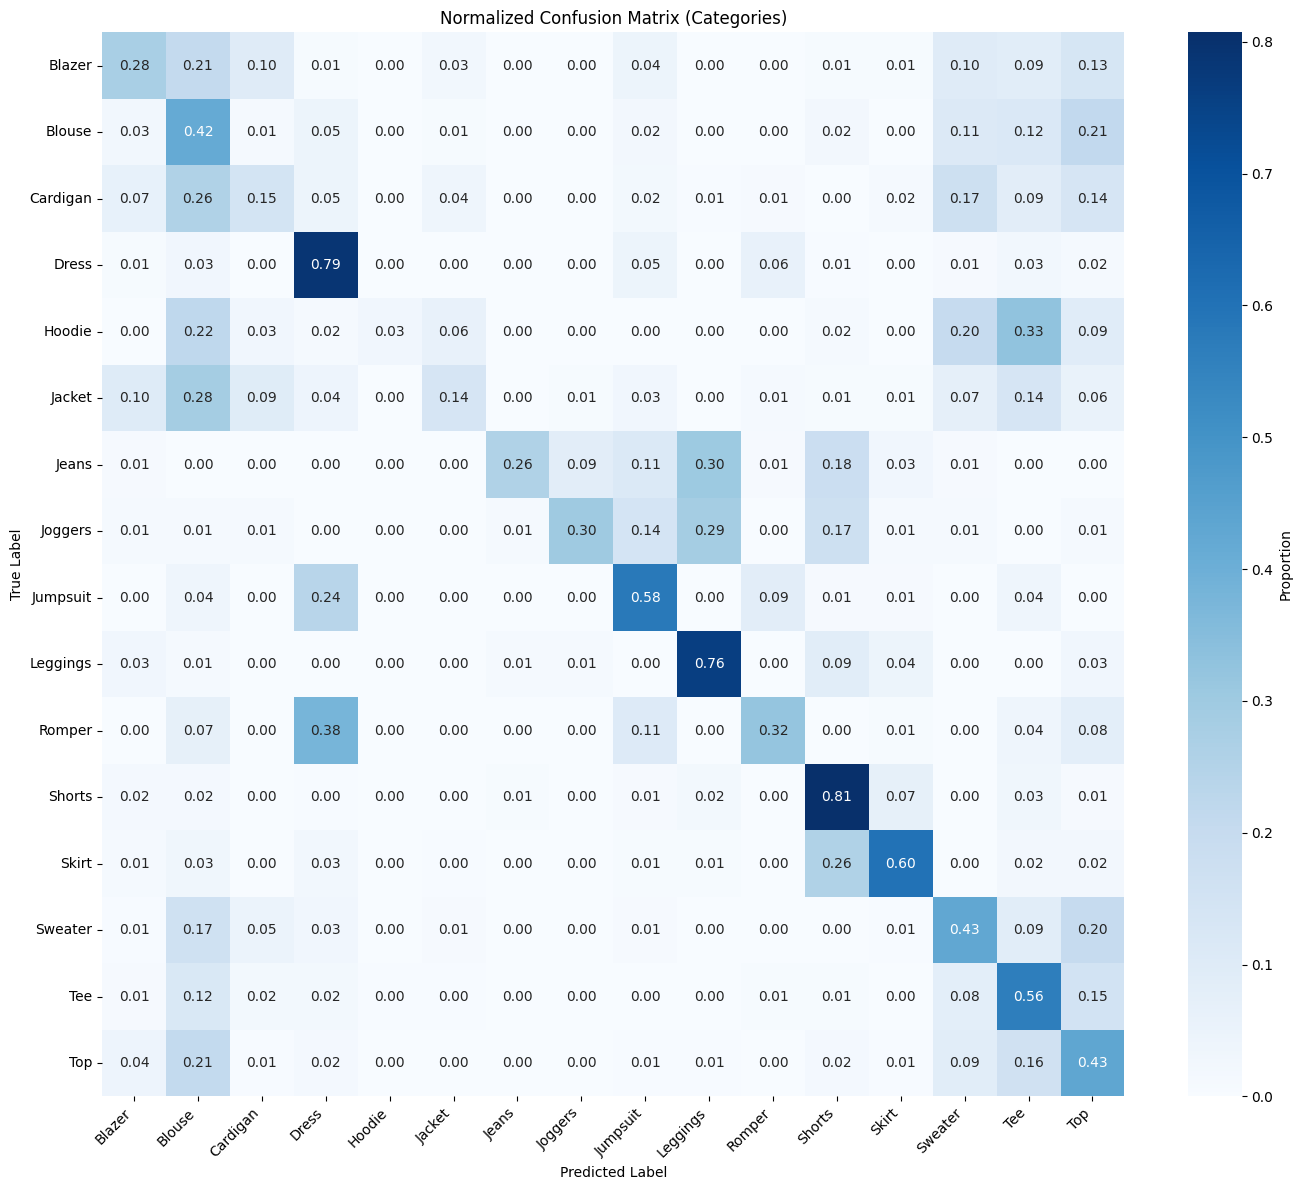

✅ Normalized confusion matrix (categories) saved at /content/confusion_matrices/cm_categories_normalized.png


In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# -------------------- Load category map --------------------
cat_map_path = "/content/annotations/cat_map_filtered.json"
with open(cat_map_path, "r") as f:
    cat_map = json.load(f)

# change the order in cat_map dict
cat_labels = [k for k, v in sorted(cat_map.items(), key=lambda x: x[1])]

save_dir = "/content/confusion_matrices"
os.makedirs(save_dir, exist_ok=True)

# -------------------- Confusion Matrix (percentage) --------------------
cm = confusion_matrix(y_true_cat, y_pred_cat, labels=list(range(len(cat_labels))))

# normalize rows for percentages
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=cat_labels,
    yticklabels=cat_labels,
    cbar_kws={"label": "Proportion"}
)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Normalized Confusion Matrix (Categories)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(save_dir, "cm_categories_normalized.png"), dpi=150)
plt.close()

print(f"✅ Normalized confusion matrix (categories) saved at {save_dir}/cm_categories_normalized.png")

# GRADIO

Now we can implement a Gradio demo to make predictions.

In [4]:
from pathlib import Path

import gradio as gr

from src.utils_gradio import gradio_predict

# ------------------------- Define Gradio interface -------------------------
description = """
<h2 style="color: #4A90E2;">Multitask Fashion Classifier</h2>
<p>Upload an image of a clothing item. The model predicts:</p>
<ul>
<li><b>Category</b> (e.g., t-shirt, dress)</li>
<li><b>Attributes</b> (e.g., floral, sleeveless, cotton)</li>
</ul>
"""

# Input and output components
inputs = gr.Image(type="pil", label="Upload Image")
outputs = [gr.Textbox(label="Predicted Category & Attributes", lines=5)]

# Optional: add some example images (paths local to Colab or URLs)
examples = [
    [
        "https://eu.manduka.com/cdn/shop/files/7516113_W_Dhara_Legging_PhantomHeather_02.jpg?v=1750410341&width=871"
    ],
    [
        "https://encrypted-tbn0.gstatic.com/shopping?q=tbn:ANd9GcSTiJkqHLvNj8r3juJZ5-_5vXmY4T26I47SXKgeiwF7xcpuukZUYjc1G28V1kYYf2jT5aAJxWzf9ieBSBA5czDjAUWz-7RQusUGbTkZtdlr0QrpC9O6-BQw"
    ],
]

iface = gr.Interface(
    fn=gradio_predict,
    inputs=inputs,
    outputs=outputs,
    title="Fashion Classifier",
    description=description,
    examples=examples,
    allow_flagging="never",
    theme="default",
)

# ------------------------- Launch -------------------------
if __name__ == "__main__":
    iface.launch(share=True)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://da052512f03c28d270.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
